# Demo with several models and words

In [ ]:
from huggingface_hub import login
from openai import OpenAI
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import json, re, os
from typing import Dict, List, Any
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import trange, tqdm

## Set-ups

In [13]:
os.environ["NEBIUS_API_KEY"] = "v1.CmMKHHN0YXRpY2tleS1lMDByNG13OHJlOTEwYXhtZjcSIXNlcnZpY2VhY2NvdW50LWUwMHZ2ZW53eDUwMDM1NTU1NjIMCOeCosgGEPu9g74COgsI54W6kwcQwMLuSkACWgNlMDA.AAAAAAAAAAF-s3IVuPd-6SwZfzos0vgqlAlUZtfge6Kj5JAVVepABWajqetR76LusvMMN1mo0E5Y5TbLdhzBkjxNaiMXxrQM"

In [14]:
MODEL_CONFIG = {
    "weak":   "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "avg":    "google/gemma-2-9b-it-fast",         
    "strong": "openai/gpt-oss-20b"
}

In [16]:
def build_model(model_name):
    return ChatOpenAI(
        base_url="https://api.studio.nebius.ai/v1",
        api_key=os.getenv("NEBIUS_API_KEY"),
        model=model_name,
        temperature=0.7
    )

models = { role: build_model(name) for role, name in MODEL_CONFIG.items() }

model_order = ["weak", "avg", "strong"]

In [44]:
embeddings = LocalSentenceTransformerEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"  # fast, strong baseline
)

'(ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)), '(Request ID: 80c07def-7916-4bcf-a025-4e8be58558a5)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


## Chain on a small dataset of words

In [29]:
def make_guess(model, chain, chain_desc):
    for i in tqdm(chain_desc, desc="Guessing"):
        guess = model.invoke([
            HumanMessage(
                f"You recieved this description: \"{i}\".\n"
                f"Guess the word. Reply with ONLY the guessed word."
            )
        ]).content.strip()

        chain.append(guess)
    return chain

In [28]:
def paraphrase(model, chain_desc):
    chain_paraphrased =[]
    for i in tqdm(chain_desc, desc="Paraphrasing"):
        new_desc = model.invoke([
            HumanMessage(
                f"You recieved this description: \"{i}\".\n"
                f"Only paraphrase it without losing the meaning. Keep the number of sentences the same. Reply only with paraphrased text."
            )
        ]).content.strip()
        chain_paraphrased.append(new_desc)

    return chain_paraphrased

In [30]:
def create_desc(model, word, n=100):
    chain_desc = []
    for _ in tqdm(range(n), desc=f"Describing '{word}'"):
        new_desc = model.invoke([
            HumanMessage(
                f"Describe this word in 3 sentences without naming it: {word}."
            )
        ]).content.strip()
        chain_desc.append(new_desc)
    return chain_desc

In [ ]:
def run_semantic_drift_process(
    *,
    word: str,
    role: str,                
    models: dict,             
    model_config: dict,        
    n: int = 100,
    iterations: int = 3,
    final_guess: bool = True,
):
    """
    Runs the (describe -> (guess -> paraphrase) x iterations -> optional final guess) process
    using the model specified by `role`.

    Returns a JSON-serializable dict (strings/lists/ints/bools only).
    """
    if role not in models:
        raise KeyError(f"role='{role}' not found in models. Available: {list(models.keys())}")
    if role not in model_config:
        raise KeyError(f"role='{role}' not found in model_config. Available: {list(model_config.keys())}")

    model = models[role]
    model_name = model_config[role]

    current_desc = create_desc(model, word, n=n)

    result = {
        "word": word,
        "n": n,
        "iterations": iterations,
        "role": role,
        "model": {"name": model_name},
        "descriptions_by_iter": [current_desc],
        "guesses_by_iter": [],
    }

    for t in trange(iterations, desc="Semantic drift iterations"):
        guesses_t = make_guess(model, chain=[], chain_desc=current_desc)
        result["guesses_by_iter"].append(guesses_t)

        current_desc = paraphrase(model, current_desc)
        result["descriptions_by_iter"].append(current_desc)

    if final_guess:
        guesses_last = make_guess(model, chain=[], chain_desc=current_desc)
        result["guesses_by_iter"].append(guesses_last)

    return result

In [ ]:
# small test
result = run_semantic_drift_process(
    word="chinchilla",
    role="weak",
    models=models,
    model_config=MODEL_CONFIG,
    n=10,
    iterations=6,
    final_guess=True,
)

print(json.dumps(result, indent=2, ensure_ascii=False))

## Evaluation

In [41]:
class LocalSentenceTransformerEmbeddings:
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2", device=None):
        self.model = SentenceTransformer(model_name, device=device)

    def embed_query(self, text: str):
        v = self.model.encode([text], normalize_embeddings=True)
        return v[0].tolist()

    def embed_documents(self, texts):
        v = self.model.encode(list(texts), normalize_embeddings=True)
        return v.tolist()


In [34]:
def normalize_token(s: str) -> str:
    """Normalize a guessed 'word' for comparison and embedding."""
    if s is None:
        return ""
    s = s.strip().lower()
    # keep letters, numbers, spaces, hyphens (optional)
    s = re.sub(r"[^a-z0-9\s\-]", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

In [62]:
def accuracy_per_iter(result: Dict[str, Any]) -> List[float]:
    gt = normalize_token(result["word"])
    acc = []
    for guesses in result["guesses_by_iter"]:
        guesses_norm = [normalize_token(g) for g in guesses]
        correct = sum(g == gt for g in guesses_norm)
        acc.append(correct / max(len(guesses_norm), 1))
    return acc


def plot_accuracy_histogram(result: Dict[str, Any]) -> None:
    acc = accuracy_per_iter(result)
    plt.bar(range(len(acc)), acc)
    plt.xlabel("Iteration")
    plt.ylabel("Correct guess ratio")
    model_name = result.get("model", {}).get("name", "unknown-model")
    plt.title(f"Accuracy vs iteration - {model_name} - {result['word']}")
    plt.show()

In [ ]:
def embed_texts_cached(embeddings: OpenAIEmbeddings, texts: List[str]) -> Dict[str, np.ndarray]:
    uniq = sorted(set(texts))
    vecs = embeddings.embed_documents(uniq)  # List[List[float]]
    return {t: np.array(v, dtype=np.float32) for t, v in zip(uniq, vecs)}


def cosine_similarity_per_iter(
    result: Dict[str, Any],
    embeddings: OpenAIEmbeddings,
) -> Dict[str, Any]:
    
    gt = normalize_token(result["word"])
    guesses_by_iter = [
        [normalize_token(g) for g in guesses]
        for guesses in result["guesses_by_iter"]
    ]

    # flatten all guesses + GT for a single embedding pass
    all_guess_tokens = [g for guesses in guesses_by_iter for g in guesses if g]
    all_to_embed = all_guess_tokens + [gt]

    cache = embed_texts_cached(embeddings, all_to_embed)
    gt_vec = cache[gt].reshape(1, -1)

    out = {
        "cosine_mean_by_iter": [],
        "cosine_median_by_iter": [],
        "cosine_all_by_iter": [],  # list of list of floats
    }

    for guesses in guesses_by_iter:
        sims = []
        for g in guesses:
            if not g:
                sims.append(float("nan"))
                continue
            g_vec = cache[g].reshape(1, -1)
            sims.append(float(cosine_similarity(g_vec, gt_vec)[0, 0]))

        sims_arr = np.array(sims, dtype=np.float32)
        out["cosine_all_by_iter"].append([float(x) for x in sims_arr])

        # ignore NaNs if any empty guesses
        valid = sims_arr[~np.isnan(sims_arr)]
        out["cosine_mean_by_iter"].append(float(np.mean(valid)) if len(valid) else float("nan"))
        out["cosine_median_by_iter"].append(float(np.median(valid)) if len(valid) else float("nan"))

    return out


def plot_cosine_curve(result: Dict[str, Any], cos_out: Dict[str, Any]) -> None:
    y = cos_out["cosine_mean_by_iter"]
    plt.plot(range(len(y)), y, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Mean cosine similarity (guess vs GT)")
    model_name = result.get("model", {}).get("name", "unknown-model")
    plt.title(f"Cosine similarity vs iteration - {model_name} - {result['word']}")
    plt.show()

In [ ]:
def eval_paraphrase_pair(refs: List[str], cands: List[str]) -> Dict[str, float]:
    
    if len(refs) != len(cands):
        raise ValueError(f"refs and cands must have same length, got {len(refs)} vs {len(cands)}")

    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    smoothie = SmoothingFunction().method4

    rougeL_scores = []
    bleu_scores = []

    for r, c in zip(refs, cands):
        r = (r or "").strip()
        c = (c or "").strip()

        rougeL_scores.append(scorer.score(r, c)["rougeL"].fmeasure)

        # BLEU needs tokenization - simple split is ok for baseline
        bleu_scores.append(
            sentence_bleu([r.split()], c.split(), smoothing_function=smoothie)
        )

    return {
        "rougeL_f1_mean": float(np.mean(rougeL_scores)),
        "bleu_mean": float(np.mean(bleu_scores)),
    }


def paraphrase_metrics_by_iter(result: Dict[str, Any]) -> Dict[str, Any]:
    
    desc = result["descriptions_by_iter"]
    out = {
        "rougeL_f1_by_iterpair": [],
        "bleu_by_iterpair": [],
    }

    for t in range(len(desc) - 1):
        m = eval_paraphrase_pair(desc[t], desc[t + 1])
        out["rougeL_f1_by_iterpair"].append(m["rougeL_f1_mean"])
        out["bleu_by_iterpair"].append(m["bleu_mean"])

    return out



def plot_paraphrase_metrics(result: Dict[str, Any], para_out: Dict[str, Any]) -> None:
    x = range(len(para_out["rougeL_f1_by_iterpair"]))
    plt.plot(x, para_out["rougeL_f1_by_iterpair"], marker="o")
    plt.xlabel("Iteration pair (t -> t+1)")
    plt.ylabel("ROUGE-L F1 (mean)")
    model_name = result.get("model", {}).get("name", "unknown-model")
    plt.title(f"ROUGE-L vs iteration - {model_name} - {result['word']}")
    plt.show()

    x = range(len(para_out["bleu_by_iterpair"]))
    plt.plot(x, para_out["bleu_by_iterpair"], marker="o")
    plt.xlabel("Iteration pair (t -> t+1)")
    plt.ylabel("BLEU (mean)")
    plt.title(f"BLEU vs iteration - {model_name} - {result['word']}")
    plt.show()


In [ ]:
def evaluate_run(
    result: Dict[str, Any],
    embeddings: OpenAIEmbeddings,
    attach_to_result: bool = True,
) -> Dict[str, Any]:
    
    eval_out = {}

    # exact-match accuracy
    eval_out["accuracy_by_iter"] = accuracy_per_iter(result)

    # embedding cosine similarity on guesses
    cos_out = cosine_similarity_per_iter(result, embeddings)
    eval_out.update(cos_out)

    # paraphrase metrics
    para_out = paraphrase_metrics_by_iter(result)
    eval_out.update(para_out)
    

    if attach_to_result:
        result["evaluation"] = eval_out

    return eval_out

## Chinchilla

### Weak

In [55]:
result = run_semantic_drift_process(
    word="chinchilla",
    role="weak",
    models=models,
    model_config=MODEL_CONFIG,
    n=10,
    iterations=6,
    final_guess=True,
)

print("len(descriptions_by_iter) =", len(result["descriptions_by_iter"]))
print("len(guesses_by_iter)      =", len(result["guesses_by_iter"]))
print("First 3 guesses at index 0:", result["guesses_by_iter"][0][:3])

print(json.dumps(result, indent=2, ensure_ascii=False))

Guessing: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

len(descriptions_by_iter) = 7
len(guesses_by_iter)      = 7
First 3 guesses at index 0: ['Vicuña', 'Chinchilla', 'Chinchilla']
{
  "word": "chinchilla",
  "n": 10,
  "iterations": 6,
  "role": "weak",
  "model": {
    "name": "meta-llama/Meta-Llama-3.1-8B-Instruct"
  },
  "descriptions_by_iter": [
    [
      "This furry creature has a soft, thick coat that it uses to keep warm in its native South American habitats. Its large eyes and ears make it highly sensitive to its surroundings, allowing it to detect even the slightest movements. This small mammal is typically found in rocky and mountainous regions, where its dense fur helps to protect it from the harsh elements.",
      "This furry creature is a small, fluffy mammal that is native to the Andes mountains in South America. It has a thick, soft coat of fur that is often white or light gray in color, and a stocky, compact body with short legs. This adorable animal is also known for its large eyes and delicate features, and is often 

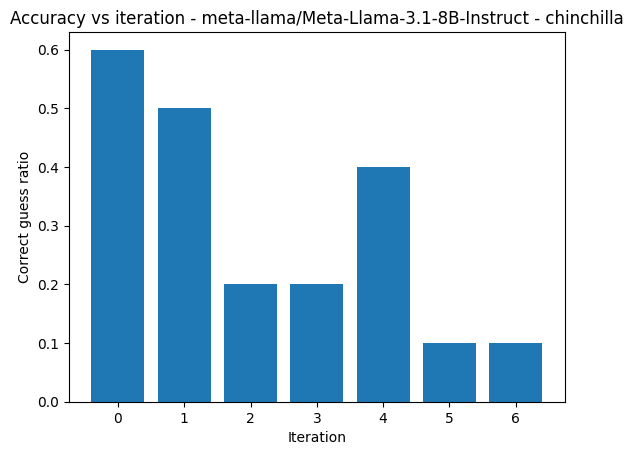

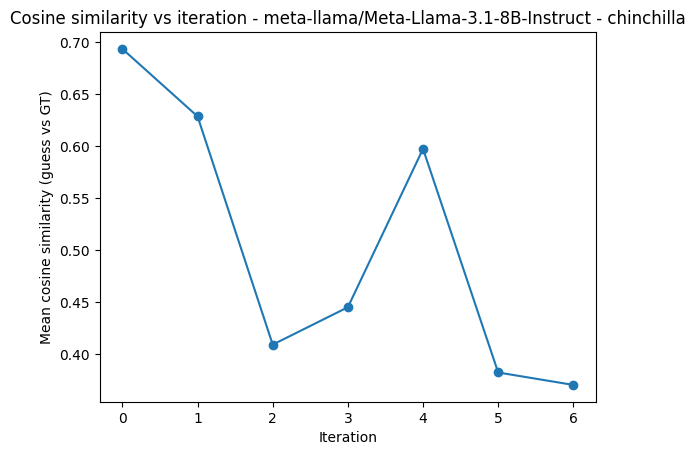

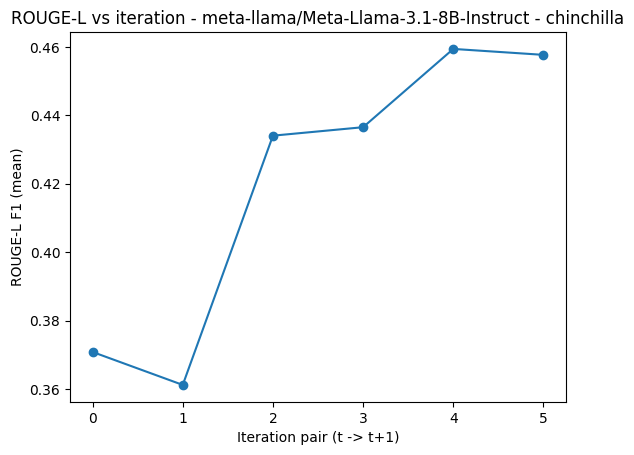

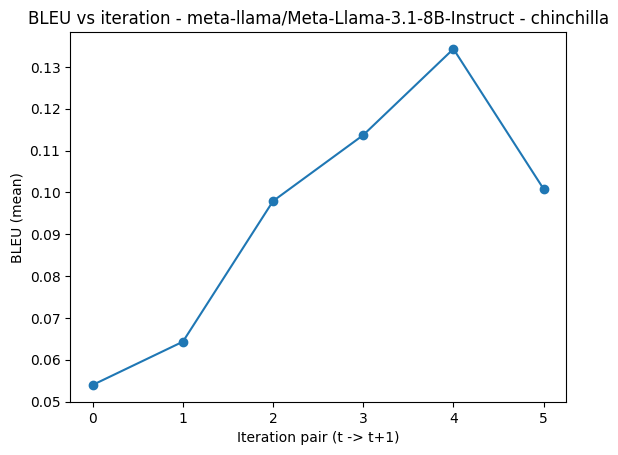

In [69]:
eval_out = evaluate_run(result, embeddings, attach_to_result=True)
plot_accuracy_histogram(result)
plot_cosine_curve(result, eval_out)
plot_paraphrase_metrics(result, eval_out)

with open("run_with_eval.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=2)

### Strong

In [57]:
result2 = run_semantic_drift_process(
    word="chinchilla",
    role="strong",
    models=models,
    model_config=MODEL_CONFIG,
    n=10,
    iterations=6,
    final_guess=True,
)

print("len(descriptions_by_iter) =", len(result2["descriptions_by_iter"]))
print("len(guesses_by_iter)      =", len(result2["guesses_by_iter"]))
print("First 3 guesses at index 0:", result2["guesses_by_iter"][0][:3])
print(json.dumps(result2, indent=2, ensure_ascii=False))

Guessing: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

len(descriptions_by_iter) = 7
len(guesses_by_iter)      = 7
First 3 guesses at index 0: ['Chinchilla', 'Chinchilla', 'Chinchilla']
{
  "word": "chinchilla",
  "n": 10,
  "iterations": 6,
  "role": "strong",
  "model": {
    "name": "openai/gpt-oss-20b"
  },
  "descriptions_by_iter": [
    [
      "This small, furry rodent is native to the high Andes and is prized for its remarkably dense and soft fur.  \nIt has a compact body, large ears, and a long, bushy tail that it uses for balance and grooming.  \nIn captivity, it is kept as a popular pet for its playful temperament and delicate coat, though its fur is also harvested for luxury textiles.",
      "This small rodent hails from the high Andes, where its thick, plush coat—often called the world’s thickest fur—helps it survive harsh, cold winds. With large, rounded ears, a long, bushy tail, and a nocturnal, hopping gait, it is a curious and agile creature that many keep as a pet. Its diet consists mainly of grasses and seeds, and its f

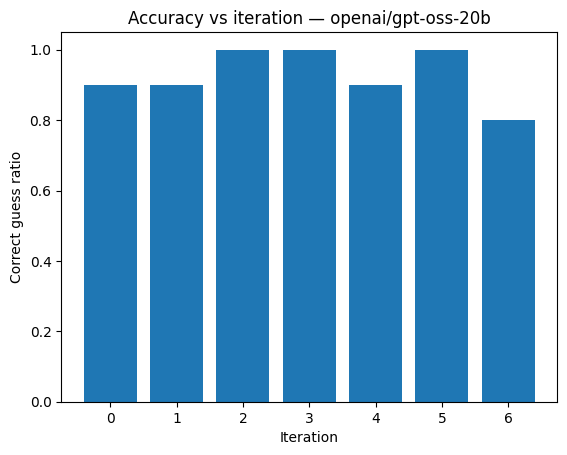

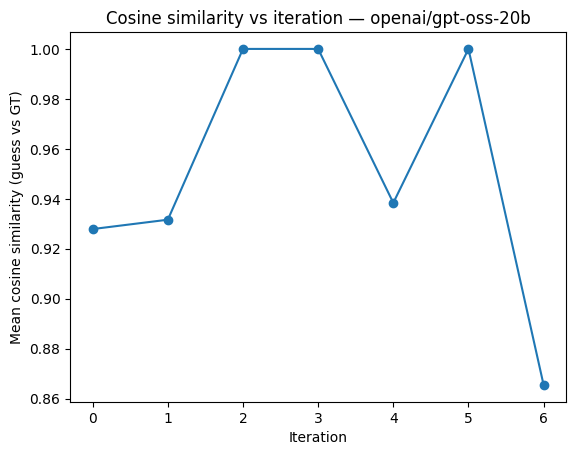

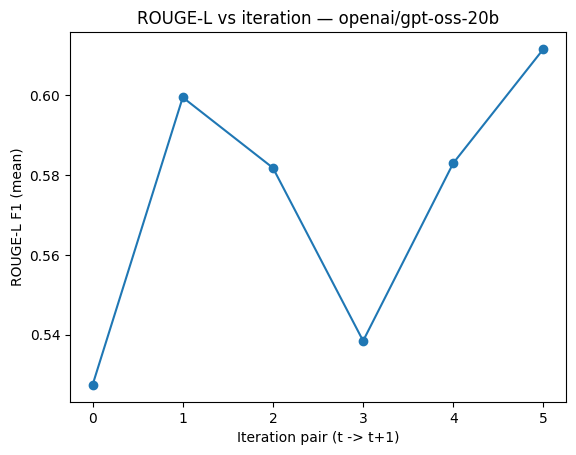

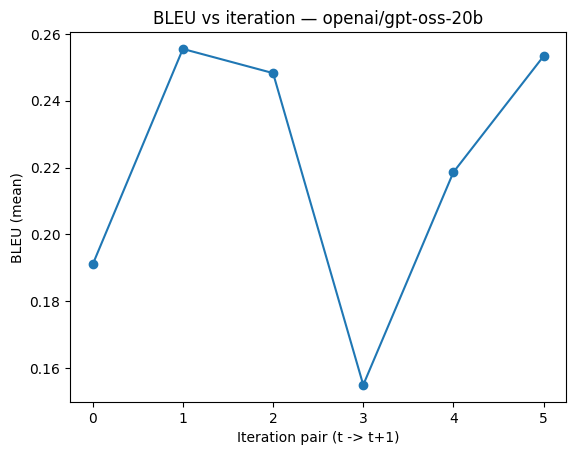

In [ ]:
eval_out = evaluate_run(result2, embeddings, attach_to_result=True)
plot_accuracy_histogram(result2)
plot_cosine_curve(result2, eval_out)
plot_paraphrase_metrics(result2, eval_out)

with open("run_with_eval.json", "w", encoding="utf-8") as f:
    json.dump(result2, f, ensure_ascii=False, indent=2)

## Friend

#### Weak

In [58]:
result3 = run_semantic_drift_process(
    word="friend",
    role="weak",
    models=models,
    model_config=MODEL_CONFIG,
    n=10,
    iterations=6,
    final_guess=True,
)

print("len(descriptions_by_iter) =", len(result3["descriptions_by_iter"]))
print("len(guesses_by_iter)      =", len(result3["guesses_by_iter"]))
print("First 3 guesses at index 0:", result3["guesses_by_iter"][0][:3])
print(json.dumps(result3, indent=2, ensure_ascii=False))

Guessing: 100%|██████████| 10/10 [00:01<00:00,  5.02it/s]

len(descriptions_by_iter) = 7
len(guesses_by_iter)      = 7
First 3 guesses at index 0: ['Friend', 'Family', 'Family.']
{
  "word": "friend",
  "n": 10,
  "iterations": 6,
  "role": "weak",
  "model": {
    "name": "meta-llama/Meta-Llama-3.1-8B-Instruct"
  },
  "descriptions_by_iter": [
    [
      "This person is someone you regularly spend time with, share experiences, and talk to, often feeling a strong sense of camaraderie and affection. They are typically someone you can rely on, trust, and confide in, and they often have a positive impact on your life. This individual can bring joy, support, and companionship, making life more enjoyable and meaningful.",
      "This person is someone with whom you share a strong bond of companionship and affection, and you feel a deep sense of comfort and trust in their presence. They are someone who accepts and supports you for who you are, and you value their opinion and advice. This individual often provides a sense of stability and security i

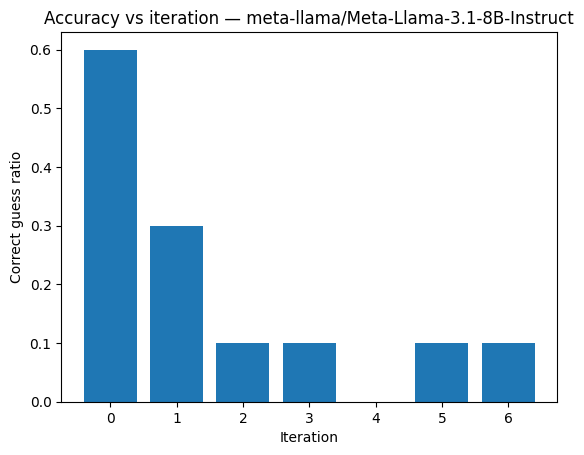

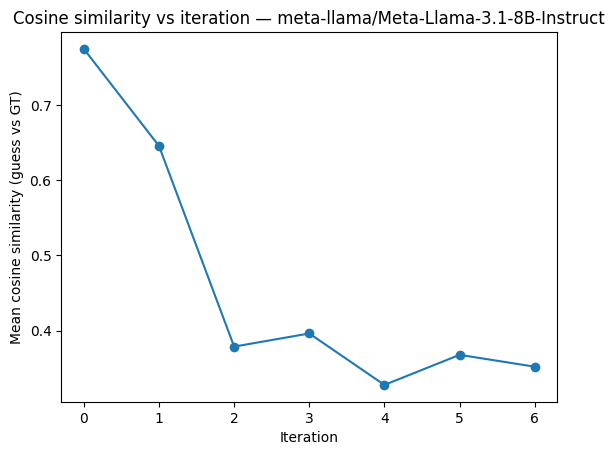

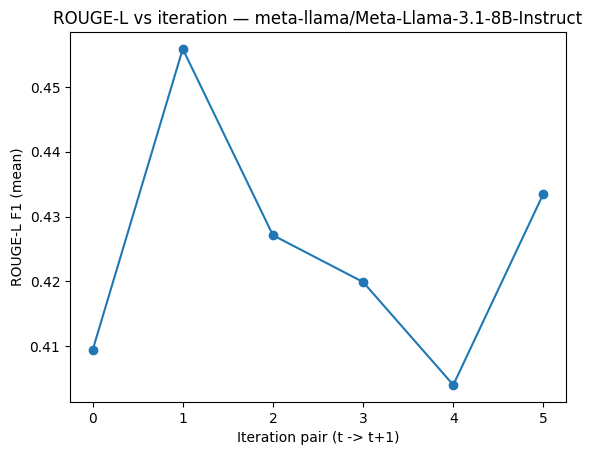

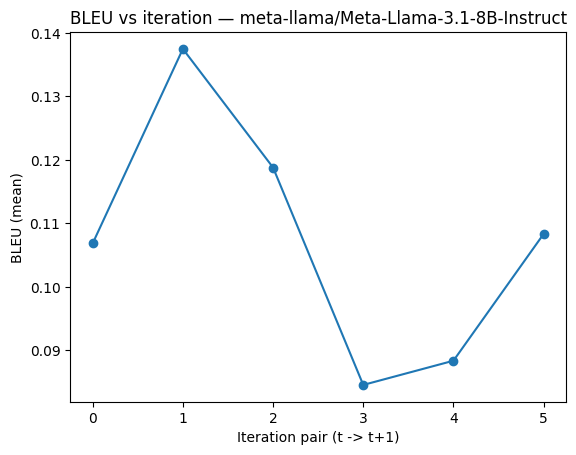

In [59]:
eval_out = evaluate_run(result3, embeddings, attach_to_result=True)
plot_accuracy_histogram(result3)
plot_cosine_curve(result3, eval_out)
plot_paraphrase_metrics(result3, eval_out)

with open("run_with_eval.json", "w", encoding="utf-8") as f:
    json.dump(result3, f, ensure_ascii=False, indent=2)

### Strong

In [60]:
result4 = run_semantic_drift_process(
    word="friend",
    role="strong",
    models=models,
    model_config=MODEL_CONFIG,
    n=10,
    iterations=6,
    final_guess=True,
)

print("len(descriptions_by_iter) =", len(result4["descriptions_by_iter"]))
print("len(guesses_by_iter)      =", len(result4["guesses_by_iter"]))
print("First 3 guesses at index 0:", result4["guesses_by_iter"][0][:3])
print(json.dumps(result4, indent=2, ensure_ascii=False))

Guessing: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

len(descriptions_by_iter) = 7
len(guesses_by_iter)      = 7
First 3 guesses at index 0: ['Friend', 'friend', 'Friend']
{
  "word": "friend",
  "n": 10,
  "iterations": 6,
  "role": "strong",
  "model": {
    "name": "openai/gpt-oss-20b"
  },
  "descriptions_by_iter": [
    [
      "This is someone you trust and share experiences with, often found in your personal circle. They provide support, companionship, and understanding, making them a pillar in your life. You rely on them for honesty, loyalty, and shared moments.",
      "A companion you trust, someone who listens with empathy and shares in your joys and challenges. You exchange confidences, laughter, and memories that deepen the connection between you. They stand by you unconditionally, offering support and honest guidance whenever you need it.",
      "A person with whom you share trust, laughter, and a willingness to listen without judgment.  \nThey stand beside you through triumphs and trials, offering support, advice, and enc

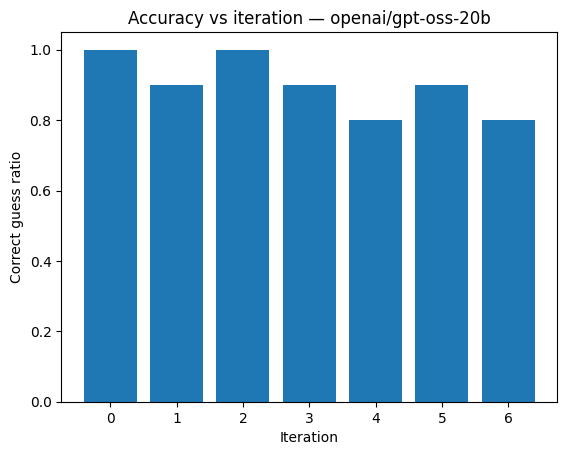

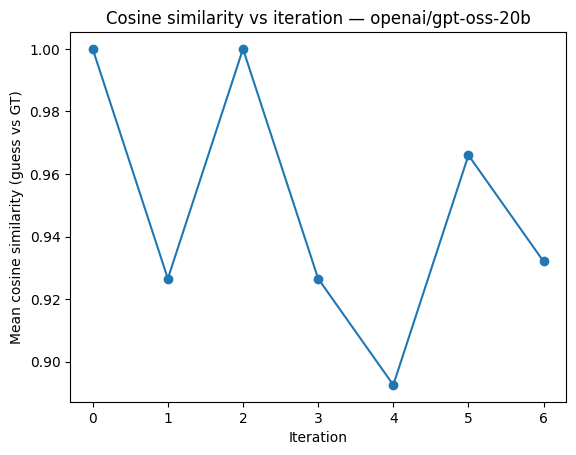

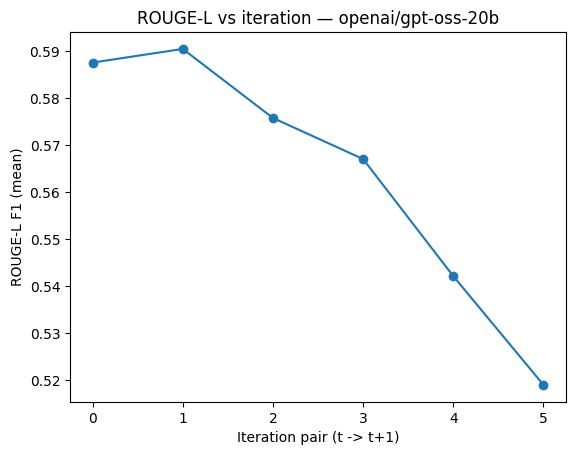

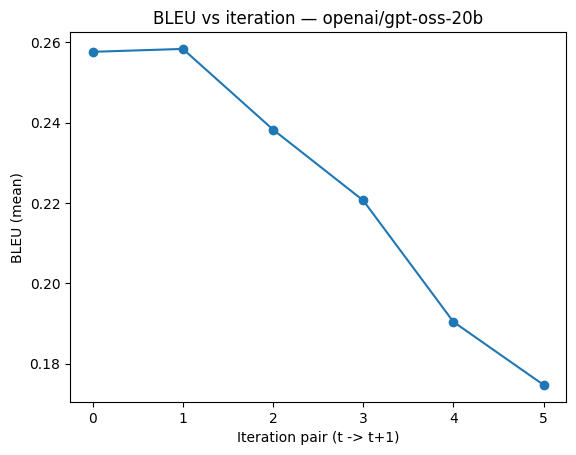

In [51]:
eval_out = evaluate_run(result4, embeddings, attach_to_result=True)
plot_accuracy_histogram(result4)
plot_cosine_curve(result4, eval_out)
plot_paraphrase_metrics(result4, eval_out)

with open("run_with_eval.json", "w", encoding="utf-8") as f:
    json.dump(result4, f, ensure_ascii=False, indent=2)

In [18]:
common_words = ['apple', 'cat', 'home', 'friend', 'jewelery']
rare_words = ['papaya', 'chinchilla', 'Laos', 'acquaintance', 'benitoite']